# Plant function vs microbial community composition

Test principle components from raw data on microbial community composition using constrained analysis of principle components and deSEQ2

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(DESeq2)
library(phyloseq)
library(doParallel)



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Formula

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘Hmisc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: 

In [4]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)



physeq.Full = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [5]:
%%R
#read non-rarified phyloseq object for use in Deseq analysis
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.NR = readRDS(F)

In [16]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

#add seed size
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GlYMA")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
head(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN     90.0000
3    B73    333.0000
4  FAGES     38.0000
5  AMAPO      0.4900
6 SORSUD     10.7000


In [120]:
%%R
#Set up N response table
#Save NResp for joining with subsets of data later
physeq.Plant = subset_samples(physeq.Full, Plant != "BARE")

    df = as(sample_data(physeq.Plant), "data.frame")
    df.Nneg <- filter(df, Treatment == "Nneg") %>% .[,c("Plot",  "Biomass_P", "Plant_N", "Plant_CN")]
    df.Npos <- filter(df, Treatment == "Npos") %>% .[,c("Plot",  "Biomass_P", "Plant_N", "Plant_CN")]
    colnames(df.Npos)[2:4] = paste(colnames(df.Npos)[2:4], "Npos", sep = "_")
    
    NResp = left_join(df.Nneg, df.Npos, by = "Plot")
    
    #Calculate fertilizer responses 
    NResp$NResp.B <- NResp$Biomass_P_Npos/NResp$Biomass_P
     NResp$NResp.N <- NResp$Plant_N_Npos/NResp$Plant_N
      NResp$NResp.CN <- NResp$Plant_CN_Npos/NResp$Plant_CN
    NResp = NResp[, c("Plot","NResp.B",  "NResp.N",  "NResp.CN")]
NResp %>% head(4)

dim(NResp)
#sample_data(physeq.Full) = df
#sample_data(physeq.Full) %>% colnames

[1] 87  4


# Annuals 

## Annuals - PCA of growth residuals

 [1] "ABUTH"  "AMAPO"  "B73"    "ECHCG"  "ELCOR"  "ERATE"  "FAGES"  "GLYMA" 
 [9] "HELAN"  "SETFA"  "SORBI"  "SORSUD"
Importance of components:
                          PC1    PC2    PC3     PC4     PC5
Standard deviation     1.8898 0.9751 0.6336 0.27573 0.01642
Proportion of Variance 0.7143 0.1902 0.0803 0.01521 0.00005
Cumulative Proportion  0.7143 0.9044 0.9847 0.99995 1.00000
                       PC1         PC2        PC3        PC4          PC5
GDD              0.5054899 -0.16677154  0.1414709 -0.8346566 -0.001252345
log(Biomass_P)   0.5240534 -0.06577403 -0.1394478  0.3057167  0.779829107
log(tN_p)        0.4741539 -0.14924677 -0.6556333  0.2066481 -0.529476166
log(Plant_CN)    0.4668768  0.06414290  0.7161766  0.3918265 -0.333878405
log(SeedSize_mg) 0.1644753  0.97029486 -0.1333281 -0.1168512 -0.006722731


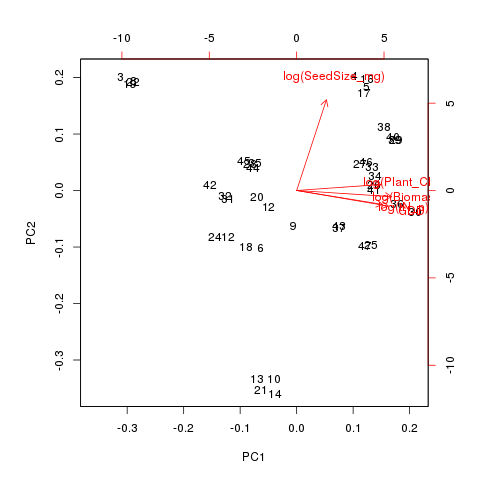

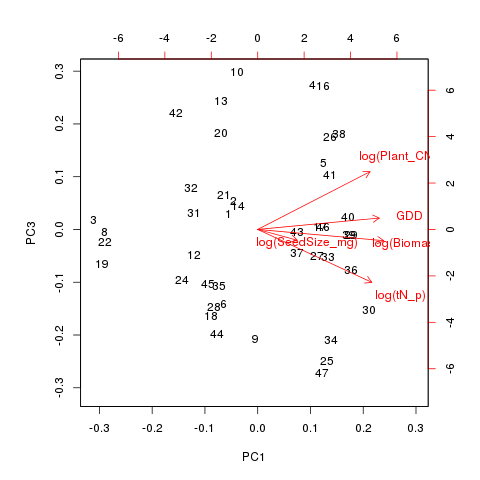

In [17]:
%%R
# PCA of annuals
A_neg = subset_samples(physeq.Full, Treatment == "Nneg"  & Type != "Maize" & Type != "BARE"  &
                       !is.na("BX_dif")| Plant == "B73" & Treatment == "Nneg"  )

A_neg_NR = subset_samples(physeq.NR, Treatment == "Nneg"  & Type != "Maize"  &  Type != "BARE" &
                       !is.na("BX_dif") | Plant == "B73" & Treatment == "Nneg" )

sd = as(sample_data(A_neg), "data.frame")
sd$Plant %>% levels %>% print

sd = left_join(sd, M_GDD, by = "DAP")
#sd = left_join(sd, NResp, by = "Plot")
sd = left_join(sd, SS, by = "Plant")
fit = prcomp(~GDD + log(Biomass_P) + log(tN_p) + log(Plant_CN) + log(SeedSize_mg), data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit, choices = c(1,2))
biplot(fit, choices = c(1,3))





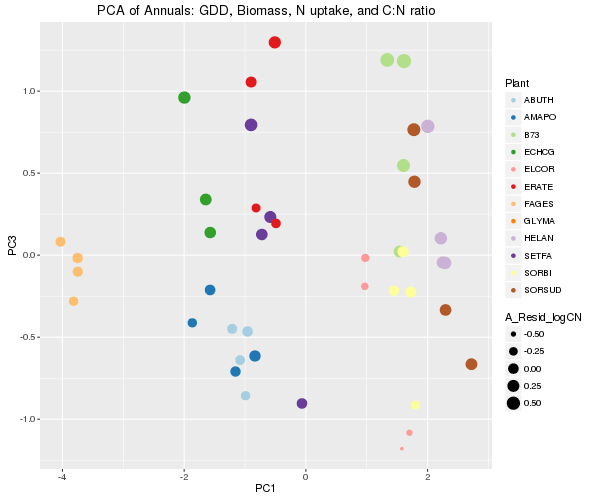

In [19]:
%%R -w 600 -h 500
S = predict(fit)[,1:4]
TM_Fit = cbind(sd, S)
row.names(TM_Fit) = TM_Fit$X.sample
sample_data(A_neg) = TM_Fit
sample_data(A_neg_NR) = TM_Fit

p = ggplot(TM_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logCN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Annuals: GDD, Biomass, N uptake, and C:N ratio")
p

## How does PC3 compare with residuals?

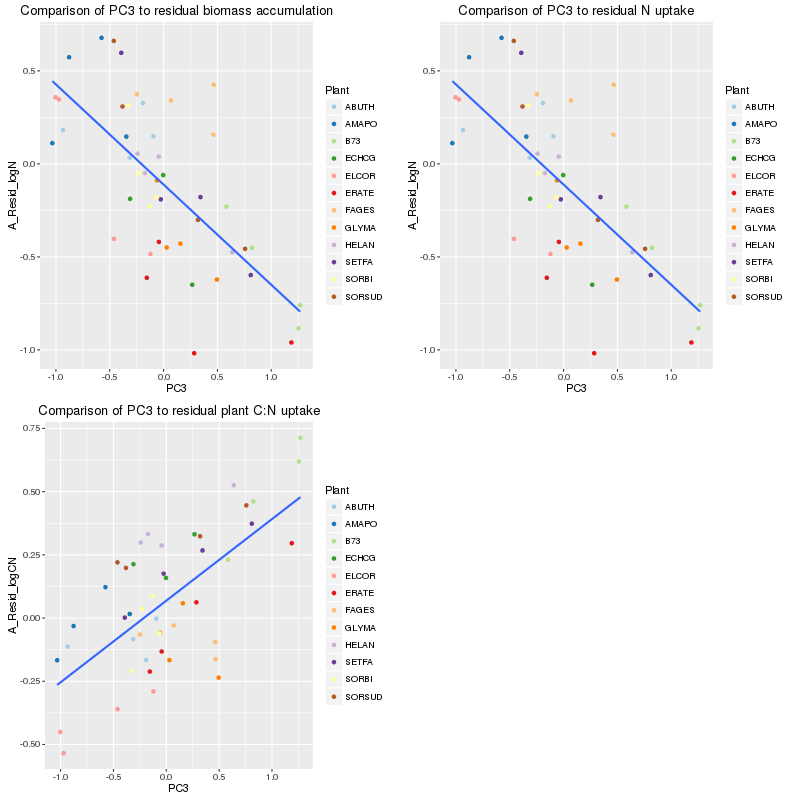

In [237]:
%%R -w 800 -h 800
p = ggplot(TM_Fit)
p = p + geom_point(aes(PC3, A_Resid_logN, fill = Plant, colour = Plant), pch = 21 )
p = p + stat_smooth(method = "lm", aes(y= A_Resid_logN, x=PC3), se = FALSE)
p = p + scale_fill_brewer(palette="Paired")
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("Comparison of PC3 to residual biomass accumulation")


p1 = ggplot(TM_Fit)
p1 = p1 + geom_point(aes(PC3, A_Resid_logN, fill = Plant, colour = Plant), pch = 21 )
p1 = p1 + stat_smooth(method = "lm", aes(y= A_Resid_logN, x=PC3), se = FALSE)
p1 = p1 + scale_fill_brewer(palette="Paired")
p1 = p1 + scale_colour_brewer(palette="Paired")
p1 = p1 + ggtitle("Comparison of PC3 to residual N uptake")


p2 = ggplot(TM_Fit)
p2 = p2 + geom_point(aes(PC3, A_Resid_logCN, fill = Plant, colour = Plant), pch = 21 )
p2 = p2 + stat_smooth(method = "lm", aes(y= A_Resid_logCN, x=PC3), se = FALSE)
p2 = p2 + scale_fill_brewer(palette="Paired")
p2 = p2 + scale_colour_brewer(palette="Paired")
p2 = p2 + ggtitle("Comparison of PC3 to residual plant C:N uptake")

grid.arrange(p, p1, p2, ncol = 2)

In [254]:
%%R
fit = lmer(BX_rel~PC1 + PC2 + PC3 + (1|Rep) + (1|Sampling) , data = TM_Fit)
print("BX_rel")
 anova(fit, ddf="Kenward-Roger", type=3) %>% print

fit = lmer(CB_rel~PC1 + PC3 + PC2 + (1|Rep) + (1|Sampling)+ (1|Sampling), data = TM_Fit)
print("CB_rel")
 anova(fit, ddf="Kenward-Roger", type=3) %>% print

fit = lmer(LAP_rel~PC1 + PC3 +  PC2 + (1|Rep) + (1|Sampling), data = TM_Fit)
print("LAP_rel")
 anova(fit, ddf="Kenward-Roger", type=3) %>% print

fit = lmer(NAG_rel~PC1 +  PC2 + PC3 + (1|Rep)+ (1|Sampling) , data = TM_Fit)
print("NAG_rel")
 anova(fit, ddf="Kenward-Roger", type=3) %>% print


[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
      Sum Sq  Mean Sq NumDF  DenDF F.value Pr(>F)
PC1 0.006124 0.006124     1  6.814 0.07547 0.7917
PC2 0.155701 0.155701     1 38.372 1.91886 0.1740
PC3 0.035430 0.035430     1 39.273 0.43664 0.5126
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
PC1 0.00697 0.00697     1  8.022  0.0813 0.78283  
PC3 0.09531 0.09531     1 42.162  1.1104 0.29799  
PC2 0.34106 0.34106     1 37.690  3.9737 0.05349 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
       Sum Sq   Mean Sq NumDF  DenDF F.value Pr(>F)
PC1 0.0005893 0.0005893     1  6.731 0.04020 0.8470
PC3 0.0084766 0.0084766     1 37.850 0.57834 0.4517
PC2 0.0000545 0.0000545     1 42.164 0.

In [246]:
%%R
library(MASS)
fit = lm(LAP_rel~A_Resid_logCN + A_Resid_logN + A_Resid_logB + NResp.B + NResp.N + NResp.CN + Sampling, data = TM_Fit)
print("LAP_activity_g")
anova(fit) %>% print
step <- stepAIC(fit, direction="backward")
step$anova # display results

[1] "LAP_activity_g"
Analysis of Variance Table

Response: LAP_rel
              Df  Sum Sq  Mean Sq F value  Pr(>F)  
A_Resid_logCN  1 0.00562 0.005616  0.3367 0.56566  
A_Resid_logN   1 0.05783 0.057835  3.4678 0.07150 .
A_Resid_logB   1 0.02727 0.027269  1.6351 0.20992  
NResp.B        1 0.01518 0.015184  0.9104 0.34693  
NResp.N        1 0.00034 0.000336  0.0202 0.88797  
NResp.CN       1 0.00765 0.007648  0.4586 0.50300  
Sampling       7 0.33501 0.047858  2.8696 0.01869 *
Residuals     33 0.55036 0.016678                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Start:  AIC=-181.02
LAP_rel ~ A_Resid_logCN + A_Resid_logN + A_Resid_logB + NResp.B + 
    NResp.N + NResp.CN + Sampling

                Df Sum of Sq     RSS     AIC
- A_Resid_logB   1   0.00854 0.55890 -182.30
- A_Resid_logN   1   0.00864 0.55900 -182.29
- NResp.CN       1   0.01143 0.56179 -182.06
- A_Resid_logCN  1   0.01225 0.56261 -181.99
- NResp.N        1   0.01591 0.56627 -181.69
- NRes

In [249]:
%%R
fit = lm(LAP_rel ~ A_Resid_logCN + NResp.B + Sampling, data = TM_Fit)
anova(fit)

Analysis of Variance Table

Response: LAP_rel
              Df  Sum Sq  Mean Sq F value   Pr(>F)   
A_Resid_logCN  1 0.00562 0.005616  0.3626 0.550756   
NResp.B        1 0.01641 0.016410  1.0594 0.310026   
Sampling       7 0.40412 0.057731  3.7271 0.003778 **
Residuals     37 0.57311 0.015489                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [240]:
%%R

fit = lmer(BX_activity_g~A_Resid_logCN + A_Resid_logN + A_Resid_logB + NResp.B + NResp.N + NResp.CN +(1|Rep) + (1|Sampling), data = TM_Fit)
print("BX_activity_g")
anova(fit) %>% print

fit = lmer(CB_activity_g~A_Resid_logCN + A_Resid_logN + A_Resid_logB + NResp.B + NResp.N + NResp.CN + (1|Rep) + (1|Sampling), data = TM_Fit)
print("CB_activity_g")
anova(fit) %>% print

fit = lmer(LAP_activity_g~A_Resid_logCN + A_Resid_logN + A_Resid_logB + NResp.B + NResp.N + NResp.CN +(1|Rep) + (1|Sampling), data = TM_Fit)
print("LAP_activity_g")
anova(fit) %>% print

fit = lmer(NAG_activity_g~A_Resid_logCN + A_Resid_logN + A_Resid_logB + NResp.B + NResp.N + NResp.CN + (1|Rep) + (1|Sampling), data = TM_Fit)
print("NAG_activity_g")
anova(fit) %>% print

[1] "BX_activity_g"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
A_Resid_logCN  0.004   0.004     1 27.606 0.00024 0.9879
A_Resid_logN   0.882   0.882     1 31.332 0.05367 0.8183
A_Resid_logB   1.930   1.930     1 30.849 0.11739 0.7342
NResp.B       46.326  46.326     1 39.516 2.81790 0.1011
NResp.N        2.588   2.588     1 37.832 0.15744 0.6938
NResp.CN       8.167   8.167     1 37.708 0.49677 0.4853
[1] "CB_activity_g"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
A_Resid_logCN 20.105  20.105     1 29.957  1.2023 0.28159  
A_Resid_logN  12.205  12.205     1 33.741  0.7299 0.39894  
A_Resid_logB  11.167  11.167     1 33.313  0.6678 0.41961  
NResp.B       86.778  86.778     1 38.706  5.1897 0.02832 *
NResp.N       14.177  14.177     1 36.513  0.8479 0.36320  
NResp

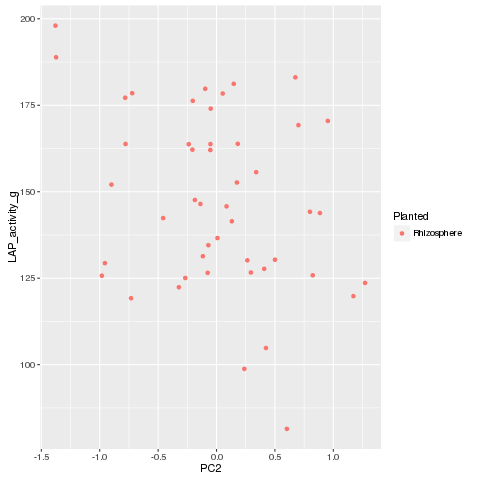

In [144]:
%%R
ggplot(TM_Fit, aes(PC2, LAP_activity_g, colour = Planted)) +
geom_point()

Notes: 
    * PC1 is highly correlated with GDD, N uptake, plant biomass and C:N.  This is expected as days to flowering is related to plant size and C:N ratio scales with plant size
    
    * PC2 is positively correlated with  N uptake, negatively correlated with C:N unclear whether this represents N limitation or genetic variation in NUE
    

## Annuals CAP with principle components

In [132]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
A_neg.wunif.dist = phyloseq::distance(A_neg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

A_neg.unif.dist = phyloseq::distance(A_neg, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

[1] 61 36 79 53 57 72 88 84
Levels: 36 53 57 61 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + PC3 + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)   
Model     3  0.22914 2.2967  0.005 **
Residual 42  1.39679                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


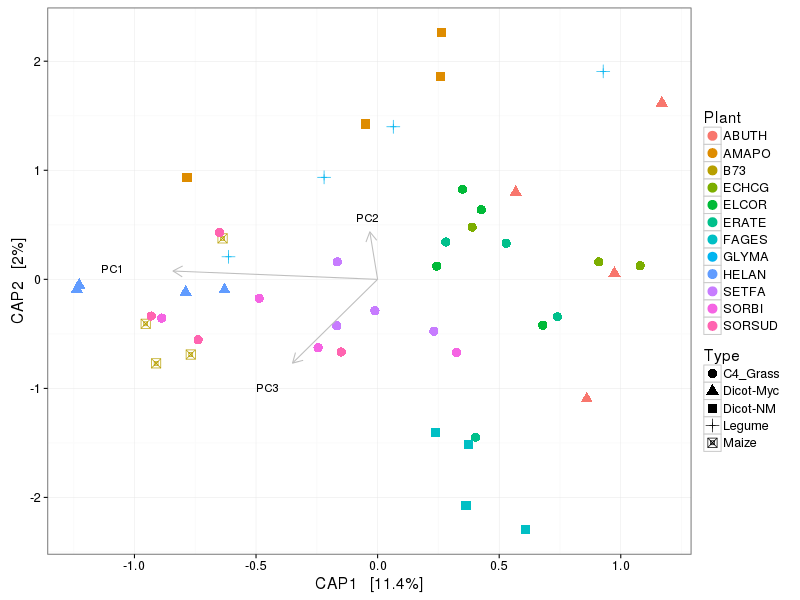

In [173]:

%%R -w 800 -h 600
phy = A_neg
dist = A_neg.wunif.dist

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
sample_data(phy)$Plant
#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + PC3 + Condition(Library) 
        )


        # CAP plot
        cap.plot <- plot_ordination(
            phy, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p


Notes:


##  Annuals Deseq of PC1
* Identify OTUs that vary with PC1 - Plant size, GDD

In [177]:
%%R
dds = phyloseq_to_deseq2(A_neg_NR, ~ Library + PC2 + PC3 + poly(PC1, 2))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NR)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept"     "Library"       "PC2"           "PC3"          
[5] "poly.PC1..2.1" "poly.PC1..2.2"


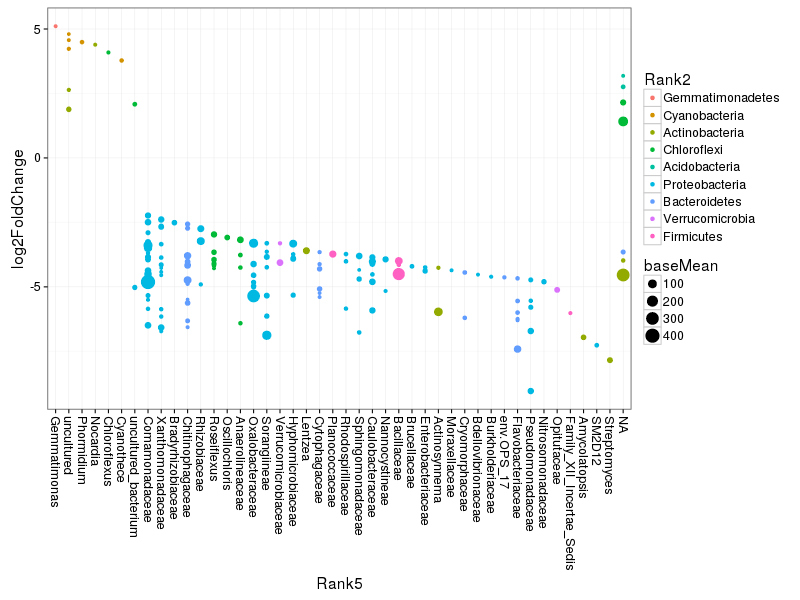

In [178]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [61]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC1")

388 OTUs vary significantly with PC1

## Annuals - deSEQ2 of PC2 
* Nresp.B positively correlated with PC2

In [183]:
%%R
dds = phyloseq_to_deseq2(A_neg_NR, ~Library + PC1 + PC3 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NR)
            if (!setequal(row.names(DF), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "PC3"       "PC2"      


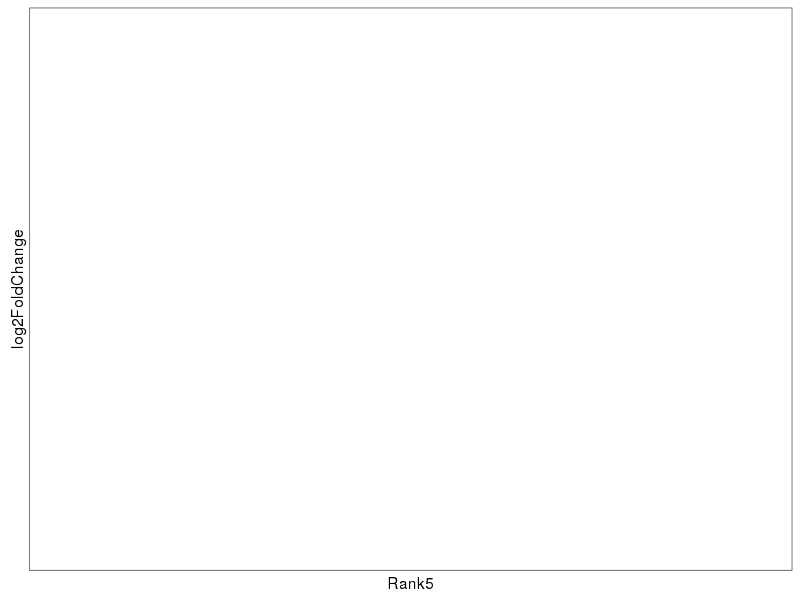

In [184]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [185]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC2")

0 OTUs vary significantly with PC2

## Annuals - Deseq of PC3
* PC3 is positively correlated with  N uptake, negatively correlated with C:N unclear whether this represents N limitation or genetic variation in NUE

In [186]:
%%R
dds = phyloseq_to_deseq2(A_neg_NR, ~Library + PC1 + PC2 + PC3)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NR)
            if (!setequal(row.names(DF), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "PC2"       "PC3"      


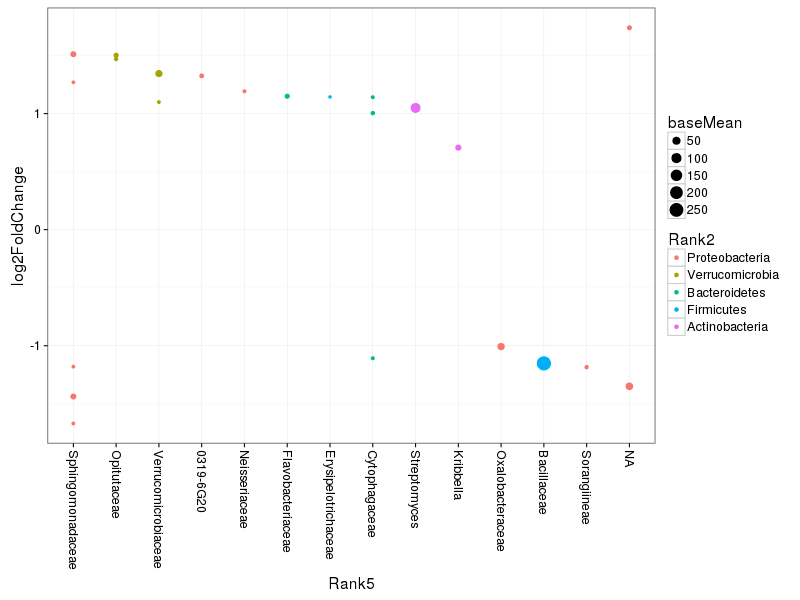

In [187]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [193]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC3")

23 OTUs vary significantly with PC3

# Check similarity of PC3 and Residual CN

In [201]:
%%R
dds = phyloseq_to_deseq2(A_neg_NR, ~Library + DAP + A_Resid_logCN)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NR)
            if (!setequal(row.names(DF), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept"     "Library"       "DAP"           "A_Resid_logCN"


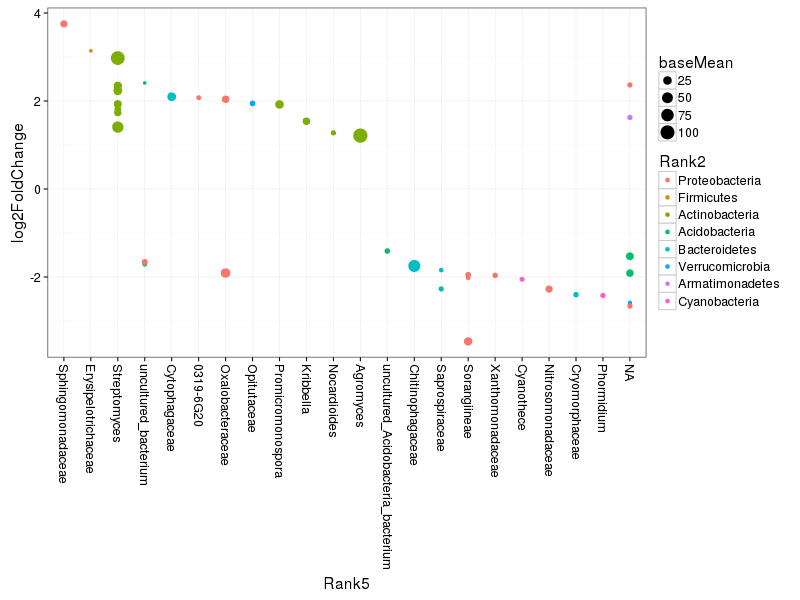

In [202]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# DeSEQ analysis without FAGES PC1

In [68]:
%%R
A_neg_NF = subset_samples(A_neg_NR, Plant != "FAGES")
dds = phyloseq_to_deseq2(A_neg_NF, ~ Library + PC2  + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NF)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC2"       "PC1"      


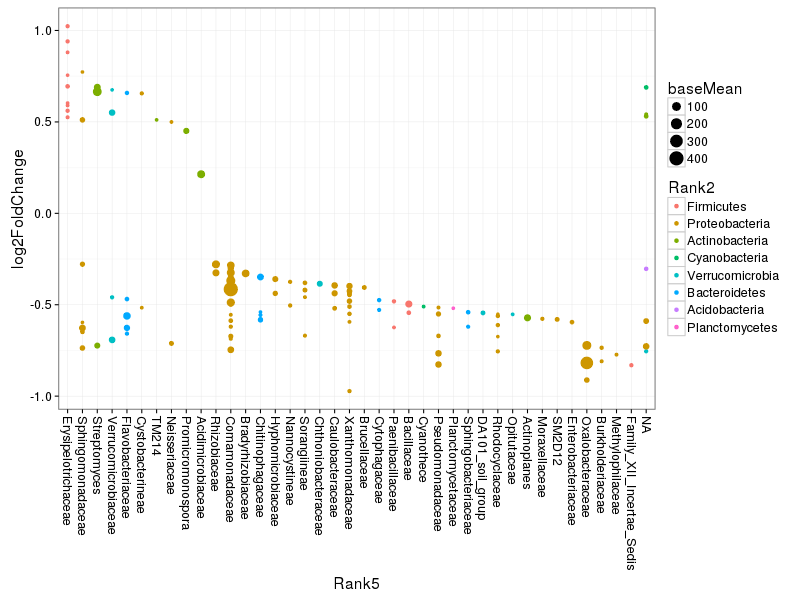

In [69]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

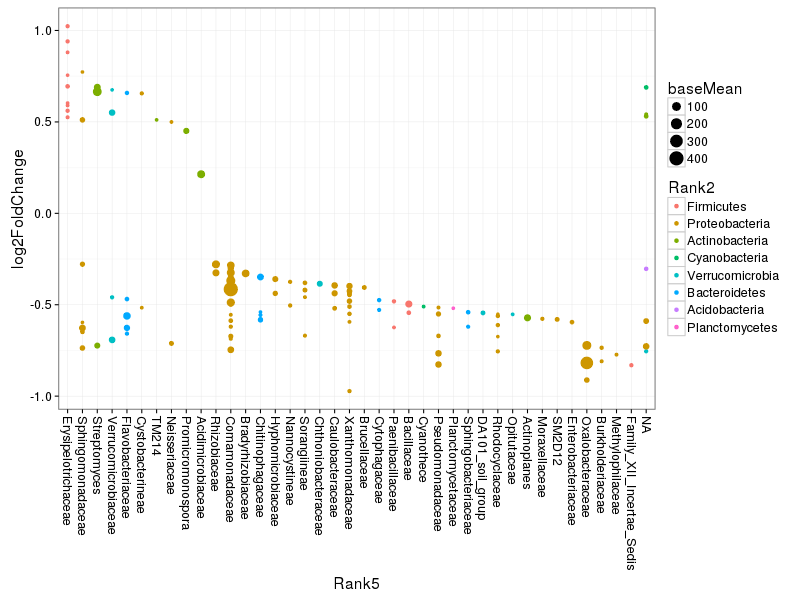

In [70]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

### Deseq analysis without FAGES using DAP instead of PC1

In [71]:
%%R
A_neg_NF = subset_samples(A_neg_NR, Plant != "FAGES")
dds = phyloseq_to_deseq2(A_neg_NF, ~ Library + DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NF)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "DAP"      


## Deseq analysis of PC2 without FAGES

In [72]:
%%R
A_neg_NF = subset_samples(A_neg_NR, Plant != "FAGES")
dds = phyloseq_to_deseq2(A_neg_NF, ~ Library + PC1  + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg_NF)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "PC2"      


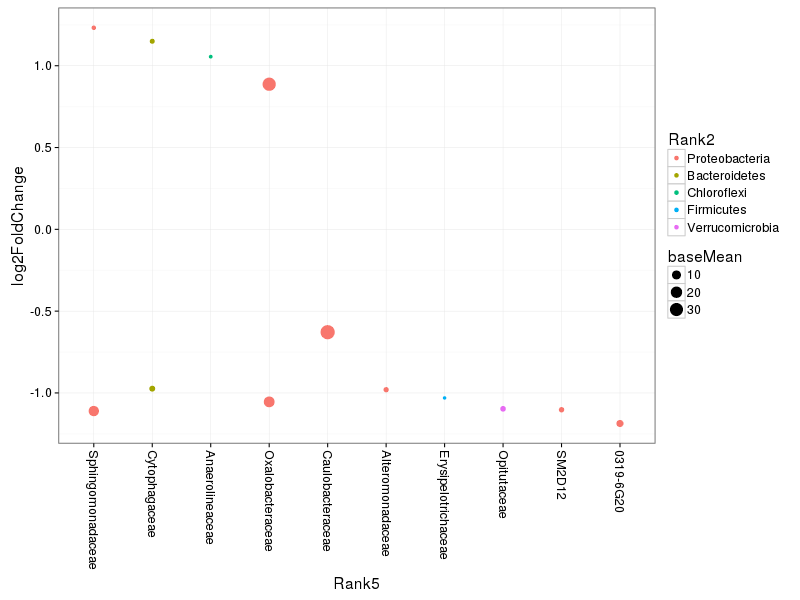

In [73]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [74]:
## How does

# Maize

## Maize - PCA of functional traits 

 [1] "75-062" "B73"    "B97"    "H99"    "Hp301"  "Il14H"  "Ki3"    "Mo18"  
 [9] "MS71"   "Oh7B"   "Tx303" 
Importance of components:
                         PC1    PC2    PC3     PC4
Standard deviation     1.481 1.1065 0.7639 0.01582
Proportion of Variance 0.548 0.3061 0.1459 0.00006
Cumulative Proportion  0.548 0.8541 0.9999 1.00000
                       PC1        PC2        PC3          PC4
GDD             0.45646188 -0.3564068 -0.8152182  0.005999287
log(Biomass_P)  0.63139543 -0.1389691  0.4189828  0.637558502
log(tN_p)       0.62384768  0.3156662  0.2062641 -0.684561217
log(Plant_CN)  -0.06161513 -0.8683413  0.3425315 -0.353354079


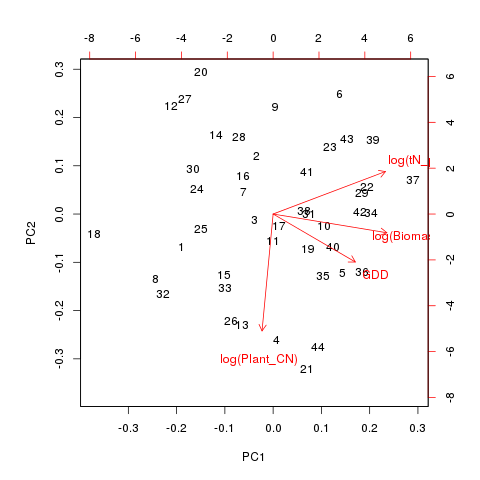

In [75]:
%%R
# PCA of annuals
M_neg = subset_samples(physeq.Full, Type == "Maize" & Treatment == "Nneg" )
# subset for later deSEQ2 analysis
M_neg_NR = subset_samples(physeq.NR, Type == "Maize" & Treatment == "Nneg" )

sd = as(sample_data(M_neg), "data.frame")
sd$Plant %>% levels %>% print

sd = left_join(sd, M_GDD, by = "DAP")

fit = prcomp(~GDD + log(Biomass_P) + log(tN_p) + log(Plant_CN), data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)




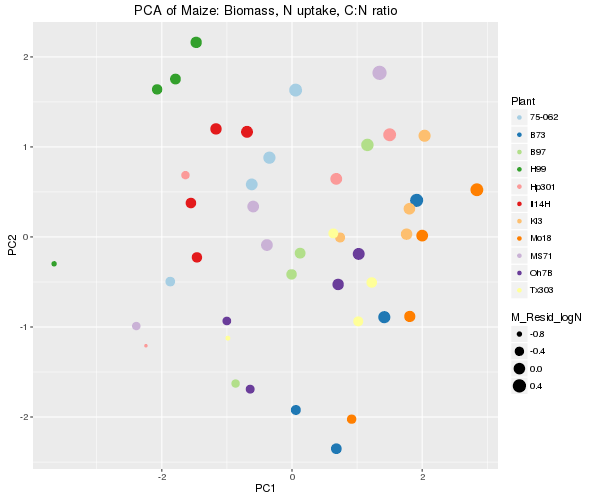

In [76]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
M_Fit = cbind(sd, S)
row.names(M_Fit) = M_Fit$X.sample
sample_data(M_neg) = M_Fit
sample_data(M_neg_NR) = M_Fit

p = ggplot(M_Fit, aes(PC1, PC2, colour = Plant, 
                       size = M_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Maize: Biomass, N uptake, C:N ratio")
p

Notes:
* PC1 positively correlated with plant size and N uptake and GDD
* PC2 negatively correlated with plant C:N and positively correlated with N uptake.  
* d15 is not included
* genotype effect is most captured on PC1 within a plant, PC1 is positively correlated with PC2 suggesting PC2is primarily N status/limitation

## Maize - CAP analysis with Principle components

In [77]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
M_neg.wunif.dist = phyloseq::distance(M_neg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

M_neg.unif.dist = phyloseq::distance(M_neg, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)



[1] 72 79 88
Levels: 72 79 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)  
Model     2  0.07496 1.8007   0.05 *
Residual 40  0.83256                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


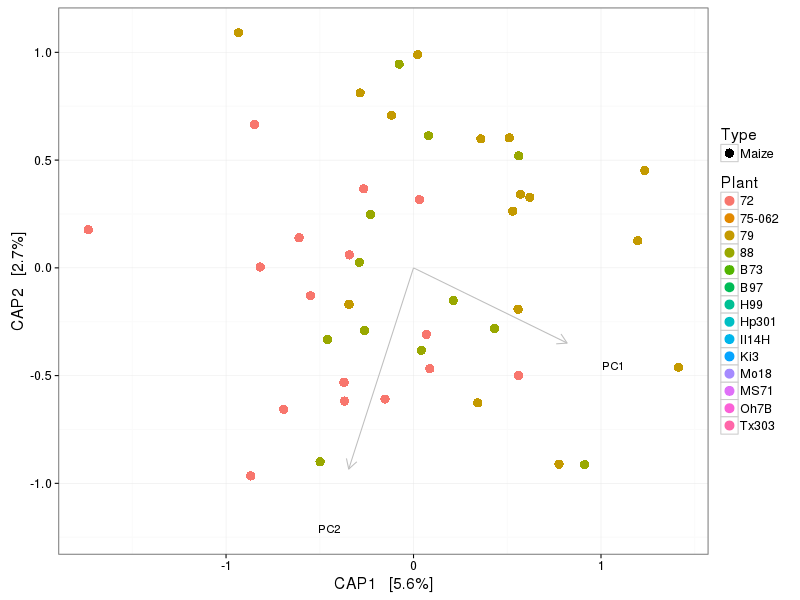

In [78]:
%%R -w 800 -h 600
### Functional controls Maize, CAP
phy = M_neg
dist = M_neg.wunif.dist

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            phy, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = as.factor(DAP)), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p


CAP model marginally significant

## Maize - Deseq of PC1
PC1 positively correlated with plant size and N uptake and GDD

In [79]:
%%R
dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC2 + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC2"       "PC1"      


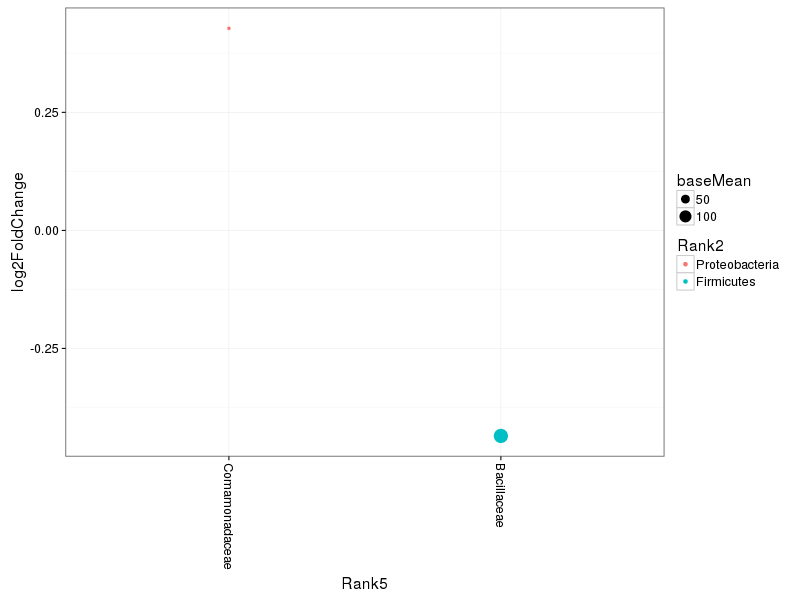

In [80]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [81]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC1")

3 OTUs vary significantly with PC1

## Maize - Deseq of PC2
PC2 negatively correlated with plant C:N and positively correlated with N uptake.

In [82]:
%%R
dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "PC2"      


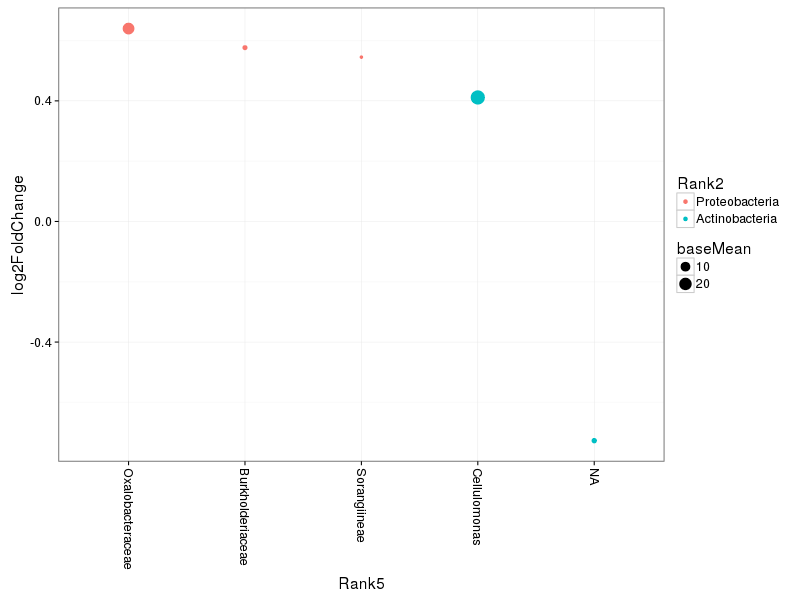

In [83]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [84]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC2")

5 OTUs vary significantly with PC2

In [85]:
%%R
sigtab

    baseMean log2FoldChange     lfcSE      stat       pvalue         padj
1 17.1082752      0.6399473 0.1409143  4.541394 5.588361e-06 0.0083378339
2  1.5624387      0.5767173 0.1406554  4.100215 4.127659e-05 0.0307923390
3  0.9651262      0.5452130 0.1369367  3.981497 6.848251e-05 0.0408703614
4 28.2362442      0.4115277 0.0948807  4.337318 1.442321e-05 0.0143462904
5  1.7717551     -0.7270209 0.1413127 -5.144765 2.678556e-07 0.0007992812
     Rank1          Rank2               Rank3              Rank4
1 Bacteria Proteobacteria  Betaproteobacteria    Burkholderiales
2 Bacteria Proteobacteria  Betaproteobacteria    Burkholderiales
3 Bacteria Proteobacteria Deltaproteobacteria       Myxococcales
4 Bacteria Actinobacteria       Micrococcales  Cellulomonadaceae
5 Bacteria Actinobacteria   Pseudonocardiales Pseudonocardiaceae
             Rank5         Rank6 Rank7 Rank8       OTU
1 Oxalobacteraceae          <NA>  <NA>  <NA> OTU.10723
2 Burkholderiaceae   Cupriavidus  <NA>  <NA>  OTU.1942
3

## Maize - DeSEQ PC3
* Not run without d15N included
* d15 negatively correlated wtih PC1 and strongly positively correlated with PC3

In [86]:
%%R
# dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC1 + PC2 + PC3)
# d_dds = DESeq(dds, parallel = TRUE)
# resultsNames(d_dds) %>% print
# DF = results(d_dds)

# supp = tax_table(A_neg)
#             if (!setequal(row.names(DF), row.names(supp))) {
#             stop("Ordination and supplementary data indices differ on the following:\n.",
#             setdiff(row.names(DF), row.names(supp)))
#         }  

#         DF = data.frame(DF, supp)
#         DF$OTU = rownames(DF)

NULL


In [87]:
%%R -w 800 -h 600
# sigtab = DF %>% filter(padj < 0.1)
# x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
# ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
#     geom_point() +
#     theme_bw(base_size = 16) +
#   theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))


NULL


In [88]:
%%R
# cat(dim(sigtab)[1], "OTUs vary significantly with PC3")

NULL


# Functional drivers using all plants together

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.7973 0.8053 0.34719 0.02265
Proportion of Variance 0.8076 0.1621 0.03014 0.00013
Cumulative Proportion  0.8076 0.9697 0.99987 1.00000
                     PC1        PC2        PC3         PC4
GDD            0.5247589 -0.2092000 -0.8250124  0.01476179
log(Biomass_P) 0.5475946  0.1702195  0.3186456  0.75473866
log(tN_p)      0.4584086  0.7021363  0.1039643 -0.53484355
log(Plant_CN)  0.4632815 -0.6589881  0.4549845 -0.37959718


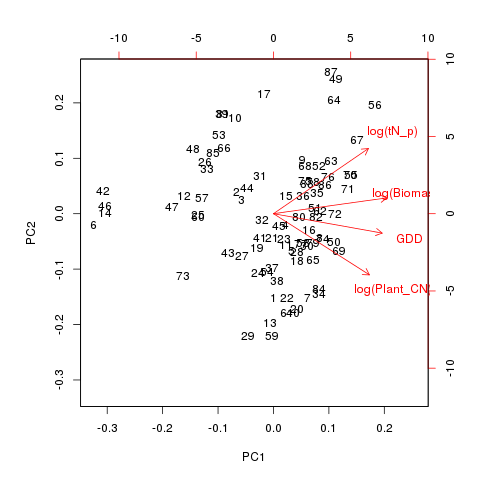

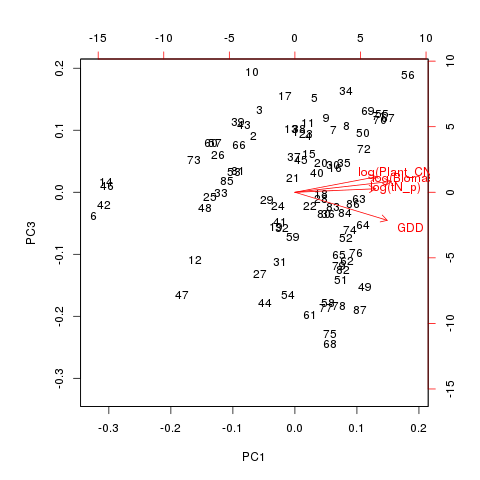

In [89]:
%%R
# PCA of all plants
Pneg = subset_samples(physeq.Full, Treatment == "Nneg"  & Type != "BARE" & !is.na("BX_dif"))

Pneg_NR = subset_samples(physeq.NR, Treatment == "Nneg"  & Type != "BARE" & !is.na("BX_dif"))

sd = as(sample_data(Pneg), "data.frame")
sd$Plant %>% levels %>% print

sd = left_join(sd, M_GDD, by = "DAP")

fit = prcomp(~GDD + log(Biomass_P) + log(tN_p) + log(Plant_CN), data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit, choices = c(1,2))
biplot(fit, choices = c(1,3))


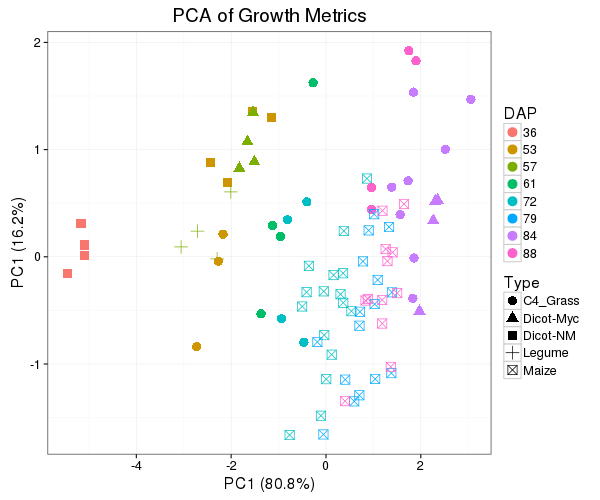

In [90]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
P_Fit = cbind(sd, S)
row.names(P_Fit) = P_Fit$X.sample
sample_data(Pneg) = P_Fit
sample_data(Pneg_NR) = P_Fit
P_Fit$DAP = as.factor(P_Fit$DAP)
p = ggplot(P_Fit, aes(PC1, PC2, colour = DAP, 
                        pch = Type))
p = p + geom_point(size = 4)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("PCA of Growth Metrics")
p = p + xlab("PC1 (80.8%)")
p = p + ylab("PC1 (16.2%)")

p

In [91]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
Pneg.wunif.dist = phyloseq::distance(Pneg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

[1] 72 61 36 79 53 57 88 84
Levels: 36 53 57 61 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     2   0.2865 4.9064  0.001 ***
Residual 83   2.4233                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


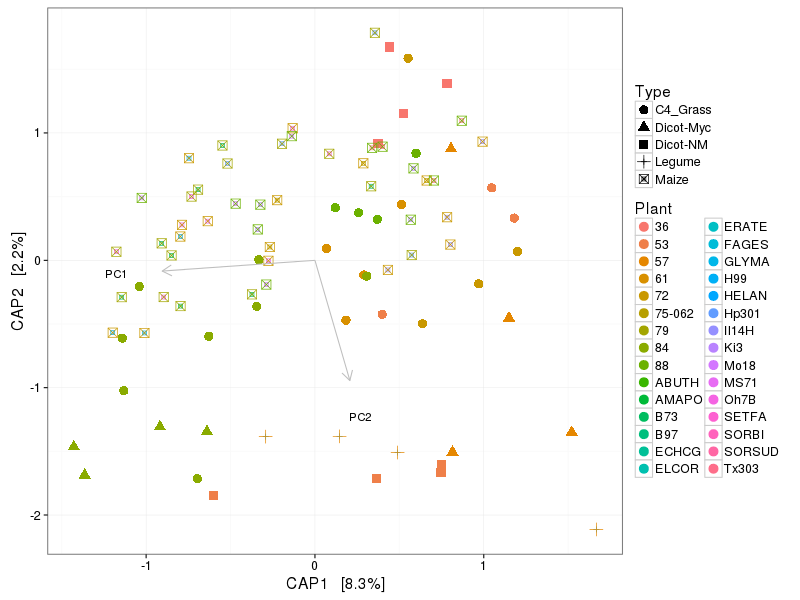

In [92]:
%%R -w 800 -h 600
### Functional controls Maize, CAP
phy = Pneg
dist = Pneg.wunif.dist

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            phy, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = as.factor(DAP)), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p


## All plants - Deseq of PC1
PC1 GDD and plant size

In [93]:
%%R
dds = phyloseq_to_deseq2(Pneg_NR, ~Library + PC2 + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(Pneg_NR)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC2"       "PC1"      


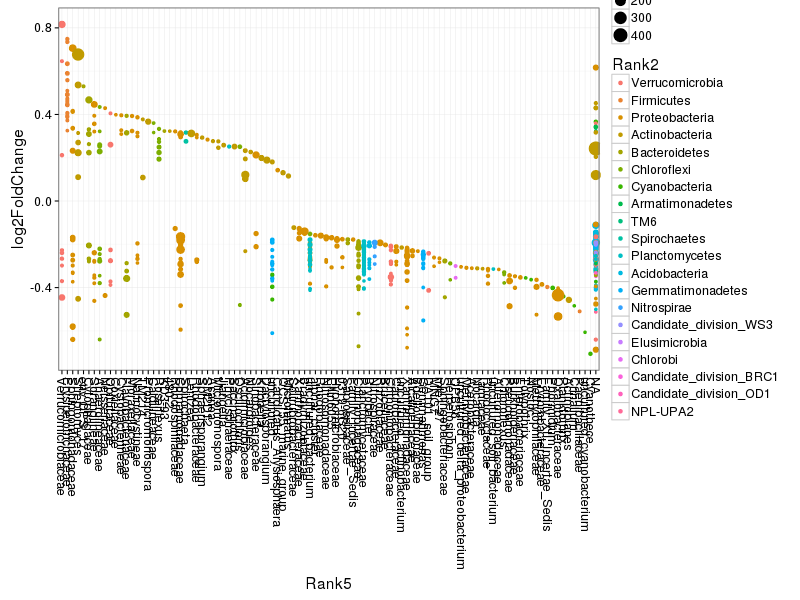

In [94]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

## Deseq of PC2, all plants
Represents total N uptake and C:N rato

In [95]:
%%R
dds = phyloseq_to_deseq2(Pneg_NR, ~Library + PC1 + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(Pneg_NR)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "PC2"      


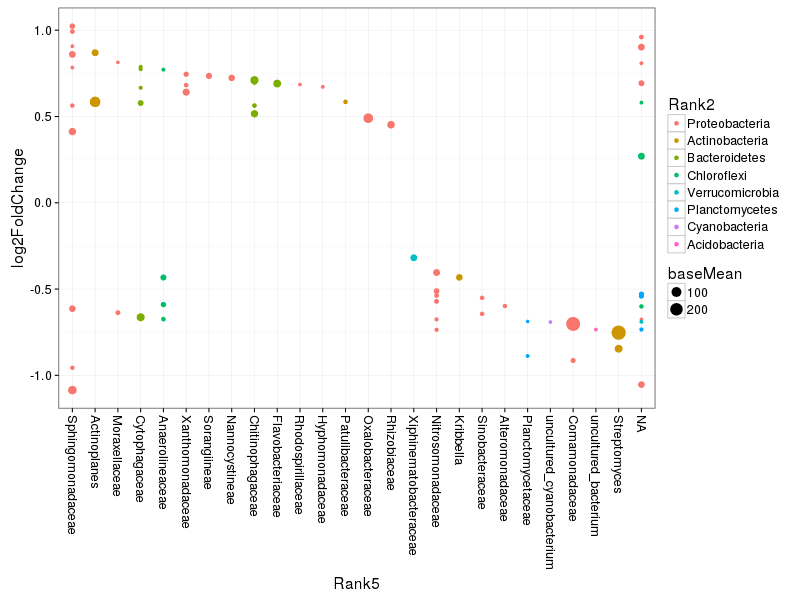

In [96]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# Functional variation in subset

[1] "ABUTH" "AMAPO" "ECHCG" "GLYMA" "H99"   "MS71"  "SETFA"
Importance of components:
                          PC1    PC2     PC3
Standard deviation     1.3856 1.0384 0.04366
Proportion of Variance 0.6399 0.3594 0.00064
Cumulative Proportion  0.6399 0.9994 1.00000
                      PC1         PC2        PC3
log(Biomass_P) -0.7212489  0.01947441 -0.6924022
log(tN_p)      -0.5522238 -0.61959984  0.5578036
log(Plant_CN)  -0.4181494  0.78467623  0.4576399


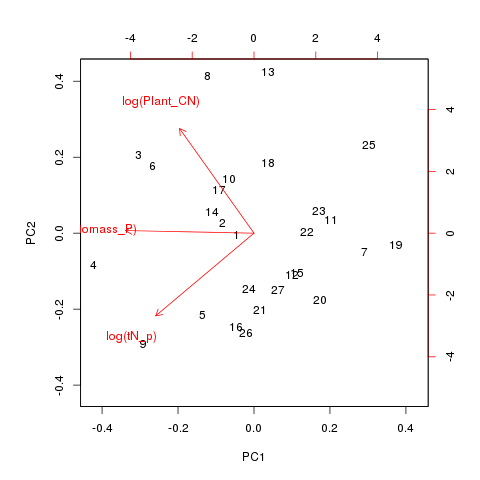

In [107]:
%%R
# PCA of annuals

ES = subset_samples(physeq.Full, Plant %in% c("ECHCG", "AMAPO", "SETFA", "H99",
                                                        "MS71", "ABUTH", "GLYMA") & Treatment == "Nneg")


sd = as(sample_data(ES), "data.frame")
sd$Plant %>% levels %>% print

sd = left_join(sd, M_GDD, by = "DAP")

fit = prcomp(~log(Biomass_P) + log(tN_p) + log(Plant_CN), data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

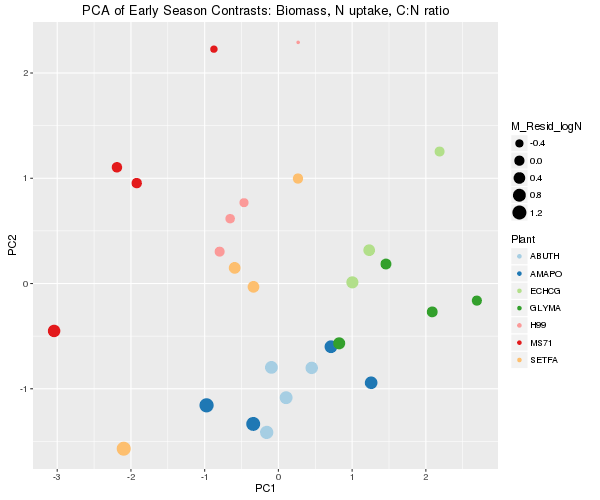

In [108]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(ES) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = M_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Early Season Contrasts: Biomass, N uptake, C:N ratio")
p